# Planetary Computer

[![colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/davemlz/spyndex/blob/main/docs/tutorials/pc.ipynb)
![level7](https://raw.githubusercontent.com/davemlz/spyndex/main/docs/_static/level8.png)

Do you know `Planetary Computer`?

Here a new level!

Level 8: `spyndex + Planetary Computer`!

Remember to install `spyndex` and `planetary-computer`!

In [ ]:
!pip install -U spyndex planetary-computer stackstac

And remember to configure `Planetary Computer`! (Enter your API token here!)

In [ ]:
!planetarycomputer configure

Now, let's start!

We are going to partially recreate this [Sentinel-2 Planetary Computer Tutorial](https://github.com/microsoft/PlanetaryComputerExamples/blob/main/tutorials/ndvi_hotspots.ipynb). But now we are going to use `spyndex` to compute some Spectral Indices!

First, import everything we need:

In [1]:
import spyndex
import stackstac

import planetary_computer as pc
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

from pystac_client import Client

Let's open the catalog!

In [2]:
catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

Define the IDs of the images we are goingto use:

In [3]:

ids = [
    "S2A_MSIL2A_20200616T141741_R010_T20LQR_20200822T232052",
    "S2B_MSIL2A_20190617T142049_R010_T20LQR_20201006T032921",
    "S2B_MSIL2A_20180712T142039_R010_T20LQR_20201011T150557",
    "S2B_MSIL2A_20170727T142039_R010_T20LQR_20210210T153028",
    "S2A_MSIL2A_20160627T142042_R010_T20LQR_20210211T234456",
]


Search for those IDs in the `Sentinel-2 L2A` Collection:

In [4]:
search = catalog.search(collections = ["sentinel-2-l2a"], ids = ids)

And sign them with the `Planetary Computer` API!

In [5]:
items = [pc.sign(item).to_dict() for item in search.get_items()]

Now, let's use `stackstac` to create a `dask.DataArray` from the images!

In [6]:
S2 = stackstac.stack(
    items,
    epsg = 32619,
    resolution = 500,
    assets = ["B04", "B05", "B06", "B07", "B08"],
    chunksize = 256,
).where(lambda x: x > 0, other = np.nan)

Let's round the time to a daily time scale:

In [7]:
S2 = S2.assign_coords(time = lambda x: x.time.dt.round("D"))

Remember also to scale the collection!

In [8]:
S2 = S2 / 10000

And now let's check what we have here...

In [9]:
S2

<xarray.DataArray 'stackstac-e6141dd496554095669cb9f3981a0a12' (time: 5, band: 5, y: 227, x: 226)>
dask.array<truediv, shape=(5, 5, 227, 226), dtype=float64, chunksize=(1, 1, 227, 226), chunktype=numpy.ndarray>
Coordinates: (12/44)
  * time                                     (time) datetime64[ns] 2016-06-28...
    id                                       (time) <U54 'S2A_MSIL2A_20160627...
  * band                                     (band) <U3 'B04' 'B05' ... 'B08'
  * x                                        (x) float64 1.362e+06 ... 1.474e+06
  * y                                        (y) float64 -9.075e+05 ... -1.02...
    s2:snow_ice_percentage                   float64 0.0
    ...                                       ...
    gsd                                      (band) int64 10 20 20 20 10
    proj:bbox                                object {699960.0, 809760.0, 8990...
    common_name                              (band) <U7 'red' ... 'nir'
    center_wavelength                        (band) float64 0.665 ... 0.842
    full_width_half_max                      (band) float64 0.038 ... 0.145
    epsg                                     int64 32619

That's INCREDIBLE! We have our images as a `dask.DataArray`!

And... if you remember the `Dask` tutorial, computing Spectral Indices with `spyndex` and `dask` is super simple!

Let's compute the `NDVI` and the `IRECI`:

In [14]:
idx = spyndex.computeIndex(
    index = ["NDVI","IRECI"],
    params = {
        "N": S2.sel(band = "B08"),
        "R": S2.sel(band = "B04"),
        "RE1": S2.sel(band = "B05"),
        "RE2": S2.sel(band = "B06"),
        "RE3": S2.sel(band = "B07"),
    }
)

Now, let's check our result:

In [15]:
idx

<xarray.DataArray 'stackstac-e6141dd496554095669cb9f3981a0a12' (index: 2, time: 5, y: 227, x: 226)>
dask.array<concatenate, shape=(2, 5, 227, 226), dtype=float64, chunksize=(1, 1, 227, 226), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2016-06-28 2017-07-28 ... 2020-06-17
  * x        (x) float64 1.362e+06 1.362e+06 1.362e+06 ... 1.474e+06 1.474e+06
  * y        (y) float64 -9.075e+05 -9.08e+05 -9.085e+05 ... -1.02e+06 -1.02e+06
  * index    (index) <U5 'NDVI' 'IRECI'

A `dask.DataArray`! You know what that means... We have to compute the indices!

In [16]:
idx = idx.compute()

And finally, you can plot the indices! Here the `NDVI`:

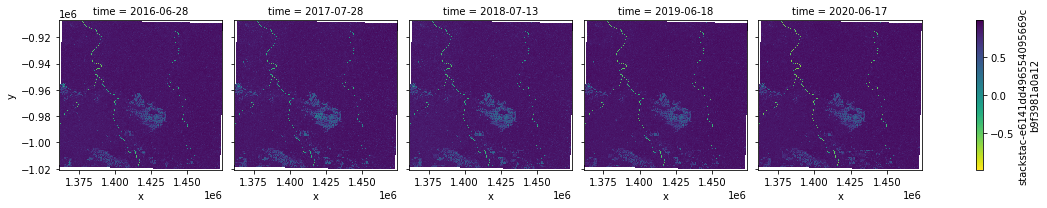

In [17]:
idx.sel(index = "NDVI").plot.imshow(col = "time",cmap = "viridis_r")

And here the `IRECI`:

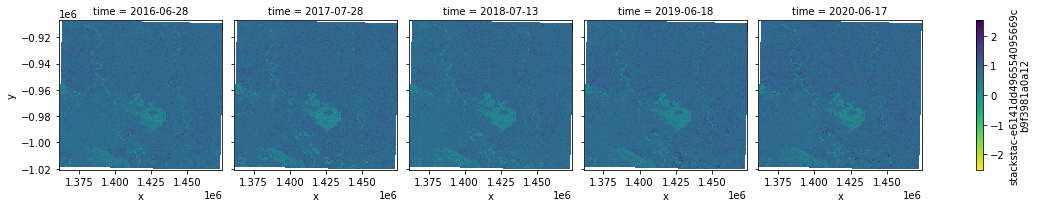

In [18]:
idx.sel(index = "IRECI").plot.imshow(col = "time",cmap = "viridis_r")

Wow! :D